# Assignment 6: Neural Network

In [1]:
import os
import pandas as pd


def read_data_from_csv(path):
    """Load datasets from CSV files.
    Args:
        path (str): Path to the CSV file.
    Returns:
        X (np.ndarray): Features of samples.
        y (np.ndarray): Labels of samples, only provided in the public datasets.
    """
    assert os.path.exists(path), f'File not found: {path}!'
    assert os.path.splitext(path)[
        -1] == '.csv', f'Unsupported file type {os.path.splitext(path)[-1]}!'

    data = pd.read_csv(path)
    column_list = data.columns.values.tolist()

    if 'Label' in column_list:
        # for the public dataset, label column is provided.
        column_list.remove('Label')
        X = data[column_list].values
        y = data['Label'].astype('int').values
        return X, y
    else:
        # for the private dataset, label column is not provided.
        X = data[column_list].values
        return X

X_public, Y_public = read_data_from_csv('assignment_6_public.csv')
print('Shape of X_public:', X_public.shape)  # n_sample, m_feature (20000, 23)
print('Shape of y_public:', Y_public.shape)  # n_sample (20000,)

X_public = X_public.astype(float)
Y_public = Y_public.astype(float)

X_public

Shape of X_public: (20000, 23)
Shape of y_public: (20000,)


array([[2.000e+04, 1.000e+00, 2.000e+00, ..., 1.376e+03, 1.000e+03,
        6.490e+02],
       [1.300e+05, 2.000e+00, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.200e+05, 1.000e+00, 1.000e+00, ..., 1.264e+03, 1.228e+03,
        1.217e+03],
       ...,
       [2.800e+05, 2.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.000e+04, 1.000e+00, 1.000e+00, ..., 7.880e+02, 5.580e+02,
        1.980e+02],
       [8.000e+04, 2.000e+00, 2.000e+00, ..., 1.200e+03, 2.400e+03,
        1.100e+03]])

## 1. Feature selection

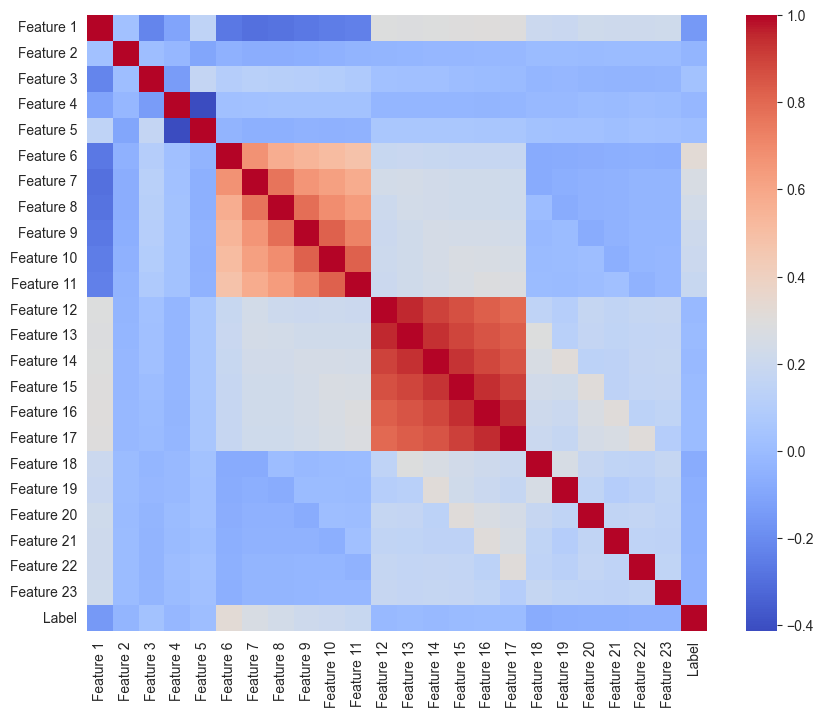

'correlation_heatmap.png'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('assignment_6_public.csv')

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', ax=ax)

# Save the heatmap to a file
heatmap_path = 'correlation_heatmap.png'
plt.savefig(heatmap_path)

#save the correlation matrix to a csv file
correlation_matrix.to_csv('correlation_matrix.csv')

# Show the heatmap
plt.show()

heatmap_path


- drop feature 13,15,16,17 (|correlation| <= 0.01 with the label)
- feature 12 & 13, 13 & 14, 14 & 15, 15 & 16, 16 & 17, 15 & 17 have a high correlation with each other(|correlation| >= 0.9)  
- In summary, drop feature 13, 15, 16, 17
- normalize the features 1,5,12,13,14,15,16,17,18,19,20,21,22,23,

In [3]:
from sklearn.preprocessing import StandardScaler
import numpy as np

normalized_features = [1,5,12,13,14,15,16,17,18,19,20,21,22,23]
normalized_columns_index = [i-1 for i in normalized_features]

scaler = StandardScaler()

X_public[:,normalized_columns_index] = scaler.fit_transform(X_public[:,normalized_columns_index])

X_public_preprocessed = np.delete(X_public, [12,14,15,16], axis=1)

def preprocess(array):
    array[:,normalized_columns_index] = scaler.transform(array[:,normalized_columns_index])
    array = np.delete(array, [12,14,15,16], axis=1)
    return array

X_public_preprocessed

array([[-1.13577157,  1.        ,  2.        , ..., -0.22583704,
        -0.25158645, -0.26200589],
       [-0.28738647,  2.        ,  2.        , ..., -0.31391918,
        -0.3172853 , -0.2983653 ],
       [-0.36451239,  1.        ,  1.        , ..., -0.23300652,
        -0.23660711, -0.2301844 ],
       ...,
       [ 0.8695023 ,  2.        ,  1.        , ..., -0.31391918,
        -0.3172853 , -0.2983653 ],
       [-1.13577157,  1.        ,  1.        , ..., -0.26347679,
        -0.28062534, -0.2872726 ],
       [-0.67301606,  2.        ,  2.        , ..., -0.23710336,
        -0.15960805, -0.23673918]])

# define model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CreditRiskModel(nn.Module):
    def __init__(self):
        super(CreditRiskModel, self).__init__()
        # Define layers
        self.fc1 = nn.Linear(19, 128)  # 19 input features
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 2)    # 2 output classes (default: yes or no)

    def forward(self, x):
        # Forward pass
        x = F.elu(self.fc1(x), alpha=1.0)
        x = F.elu(self.fc2(x), alpha=1.0)
        x = F.elu(self.fc3(x), alpha=1.0)
        x = F.elu(self.fc4(x), alpha=1.0)
        x = self.fc5(x)
        return x

# Initialize the model
model = CreditRiskModel()
print(model)



CreditRiskModel(
  (fc1): Linear(in_features=19, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=2, bias=True)
)


### define device

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


### train model

Epoch 0 | Loss: 0.6403 | Accuracy: 0.7832
Epoch 100 | Loss: 0.4424 | Accuracy: 0.8184
Epoch 200 | Loss: 0.4417 | Accuracy: 0.8190
Epoch 300 | Loss: 0.4415 | Accuracy: 0.8198
Epoch 400 | Loss: 0.4414 | Accuracy: 0.8196
Epoch 500 | Loss: 0.4413 | Accuracy: 0.8198
Epoch 600 | Loss: 0.4413 | Accuracy: 0.8198
Epoch 700 | Loss: 0.4413 | Accuracy: 0.8206
Epoch 800 | Loss: 0.4412 | Accuracy: 0.8206
Epoch 900 | Loss: 0.4412 | Accuracy: 0.8206


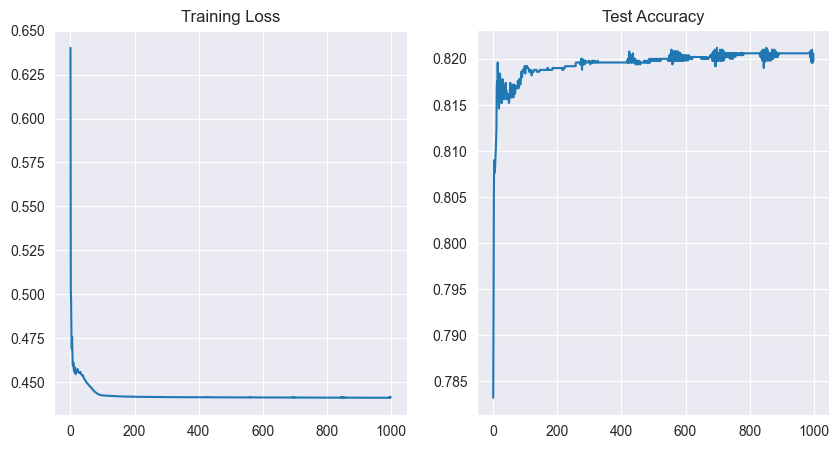

In [6]:
from sklearn.metrics import accuracy_score
from torch import optim
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_public_preprocessed, Y_public,
    test_size=0.25, random_state=73)  

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
Y_train = torch.LongTensor(Y_train)
Y_test = torch.LongTensor(Y_test)

model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01,weight_decay=0.01) 

losses = []
accuracies = []

for i in range(1000):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train.to(device))
    loss = criterion(outputs, Y_train.to(device))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test.to(device))
        predicted = torch.argmax(test_outputs, 1)
        accuracy = accuracy_score(Y_test.cpu(), predicted.cpu())
        accuracies.append(accuracy)


    if i % 100 == 0:
        print(f'Epoch {i} | Loss: {loss.item():.4f} | Accuracy: {accuracy:.4f}')

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(losses)   # Plot training loss over epochs
plt.title('Training Loss')
plt.subplot(1, 2, 2)
plt.plot(accuracies)   # Plot test accuracy over epochs
plt.title('Test Accuracy')
plt.show()

In [7]:
X_private = read_data_from_csv('assignment_6_private.csv')
print('Shape of X_private:', X_private.shape)  # k_sample, m_feature (5000, 23)
print('type of X_private:', X_private.dtype)  # k_sample (5000,)

X_private = X_private.astype(float)

X_private_preprocessed = preprocess(X_private)

X_private_preprocessed

Shape of X_private: (5000, 23)
type of X_private: int64


array([[ 1.79501331,  1.        ,  2.        , ...,  0.10216653,
         0.01120896, -0.12962178],
       [ 1.71788739,  2.        ,  2.        , ..., -0.1707857 ,
        -0.1854277 , -0.20872731],
       [ 0.09824312,  2.        ,  2.        , ..., -0.28856996,
        -0.10008489, -0.1131508 ],
       ...,
       [-0.90439381,  2.        ,  2.        , ..., -0.29471523,
        -0.29100576, -0.25354631],
       [-0.13313464,  2.        ,  2.        , ..., -0.31391918,
        -0.3172853 , -0.2983653 ],
       [-0.51876422,  2.        ,  2.        , ..., -0.05786644,
        -0.05448989, -0.13029406]])

### make predictions

In [8]:
import numpy as np

model.eval()
test_outputs = model(torch.FloatTensor(X_private_preprocessed).to(device))
_,predicted = torch.max(test_outputs.data, 1)
preds = predicted.cpu().numpy()

'''
CODE HERE!
e.g.,
preds = np.full(len(X_private), -1, dtype=int)
'''

submission = pd.DataFrame({'Label': preds})
submission.to_csv('assignment_6.csv', index=True, index_label='Id')